### Exercise 5

Forecasting<br>
• Split real-world time series into train/test sets.<br>
• Fit ARIMA on training, forecast test observations.<br>
• Plot forecasts vs. actuals, what patterns does your model capture or miss?<br>
• Perform residual analysis<br>
• Generate 80% / 95% forecast intervals. Are values within the intervals? What does this imply?<br>

Evaluation workflow<br>
• Use cross-validation to generate different validation folds<br>
• Compute rolling forecast performance. Which metric is best suited for your data?<br>
• Compare ARIMA with baseline models (mean, naïve, seasonal naïve).<br>
• Review sktime forecasting notebook and test different forecasting approaches.<br>
• Select best model and evaluate performance on the test set.<br>

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA as sm_ARIMA

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sktime.utils.plotting import plot_interval, plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA

from utils import time_plot, get_figure, baseline_forecasting, residual_analysis_plots, acf_plot, pacf_plot, stationarity_tests, split_time_series, evaluate_forecaster

In [32]:
import requests

import pandas as pd
import requests

def get_germany_births() -> pd.DataFrame:
    country, nyears = "DE", 20

    url = (
        "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/demo_fmonth"
        f"?format=JSON&geo={country}&sinceTimePeriod=2000"
    )
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    raw = resp.json()

    # time dimension
    time_index = raw["dimension"]["time"]["category"]["index"] 
    years = sorted(time_index.items(), key=lambda x: x[1])   

    # month dimension 
    month_index = raw["dimension"]["month"]["category"]["index"]
    month_codes = [m for m in month_index.keys() if m.startswith("M")]

    values = raw.get("value", {})

    # 
    wide_rows = []
    for mcode in month_codes:
        row = {"month": mcode, "country": country}
        for year_str, year_idx in years:

            month_idx = month_index[mcode]
            n_years = len(years)
            pos = str((month_idx * n_years) + year_idx)
            row[year_str] = values.get(pos, None)
        wide_rows.append(row)

    df = pd.DataFrame(wide_rows)

    month_mapping = {
        "M01": "jan", "M02": "feb", "M03": "mar", "M04": "apr",
        "M05": "may", "M06": "jun", "M07": "jul", "M08": "aug",
        "M09": "sep", "M10": "oct", "M11": "nov", "M12": "dec",
    }
    df["month"] = df["month"].map(month_mapping)

    df = df.melt(id_vars=["month", "country"], var_name="year", value_name="births")
    df = df.dropna()
    df["year"] = df["year"].astype(int)

    df["month"] = pd.Categorical(
        df["month"],
        categories=list(month_mapping.values()),
        ordered=True,
    )

    df = df.sort_values(by=["year", "month"])
    df = df[df["country"] == country]
    df = df[df["year"] > df["year"].max() - nyears]

    df["time"] = pd.date_range(
        start=f"{df['year'].min()}-01-01",
        periods=len(df),
        freq="ME",
    )

    assert all(
        df["time"].dt.strftime("%b").str.lower() == df["month"]
    ), "Mismatch between 'time' and 'month' columns"

    df = df.reset_index(drop=True)
    return df


### Forecasting

In [33]:
data = get_germany_births()

print(data.head())

  month country  year   births       time
0   jan      DE  2005  57338.0 2005-01-31
1   feb      DE  2005  53165.0 2005-02-28
2   mar      DE  2005  57071.0 2005-03-31
3   apr      DE  2005  55684.0 2005-04-30
4   may      DE  2005  56866.0 2005-05-31


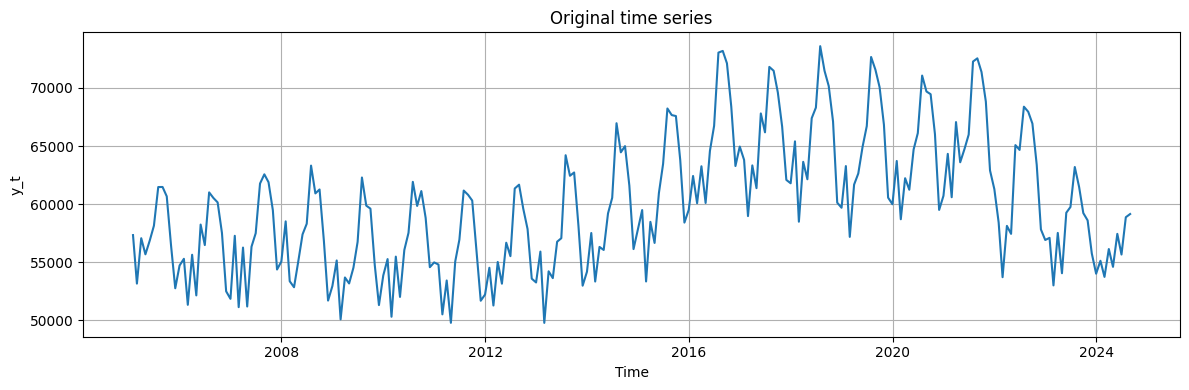

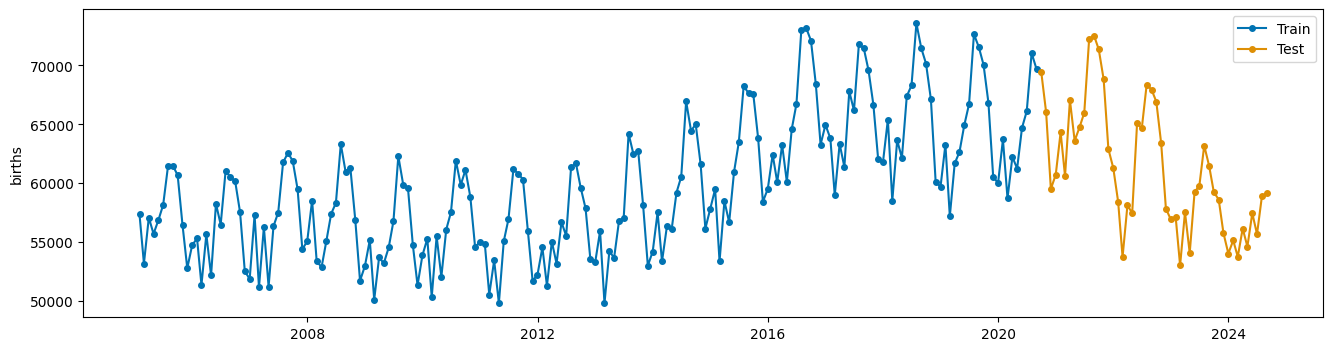

In [34]:

data = get_germany_births()
data["time"] = pd.to_datetime(data["time"])

y = data.set_index("time")["births"]

fig, axes = get_figure()
ax = axes[0]

time_plot(
    x=y.index,
    y=y.values,
    title="Original time series",
    xlabel="Time",
    ylabel="y_t",
    ax=ax,
)
fig.tight_layout()

full_train, (train, eval), test = split_time_series(y)

plot_series(full_train, test, labels=['Train', 'Test'])

fh = list(range(len(test)))  # forecasting horizon for test period


In [35]:
y_float = data["births"].astype("float64").dropna()
stationarity_tests(y_float)


Stationarity Test Results:
	- ADF: Non-Stationary (p-value: 0.7727)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Non-Stationary (p-value: 0.0005)
	- ZA: Non-Stationary (p-value: 0.9983)


Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0020)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Stationary (p-value: 0.9761)
	- ZA: Stationary (p-value: 0.0000)


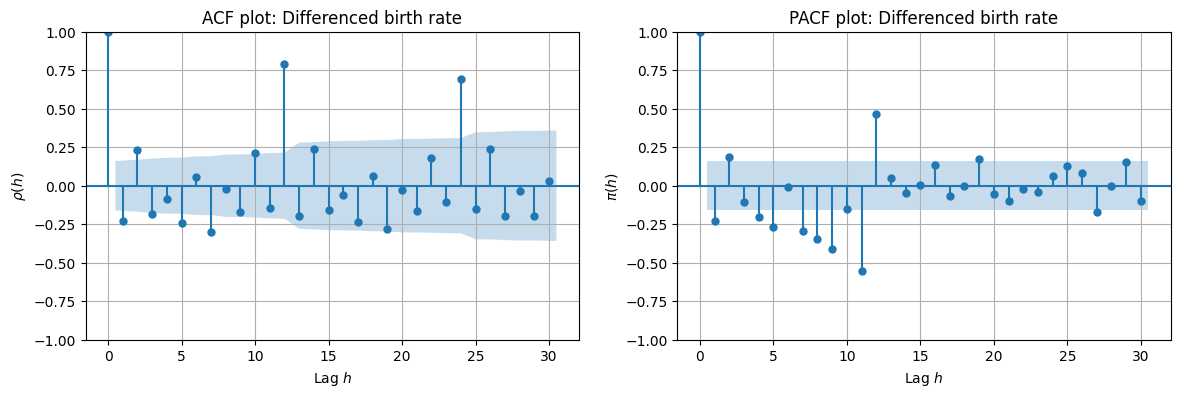

In [36]:
# Differencing 
differenced_data = train.diff().dropna()
stationarity_tests(differenced_data)

fig, (ax1, ax2) = get_figure(ncols=2, figsize=(14, 4))
acf_plot(differenced_data, 30, ax1, title="Differenced birth rate")
pacf_plot(differenced_data, 30, ax2, title="Differenced birth rate")



Before differencing, most stationarity tests (ADF, KPSS, ZA) indicate that the series is non-stationary. After applying first differencing, all tests consistently show stationarity. Therefore, using one difference (d = 1) in the ARIMA model is appropriate.

/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


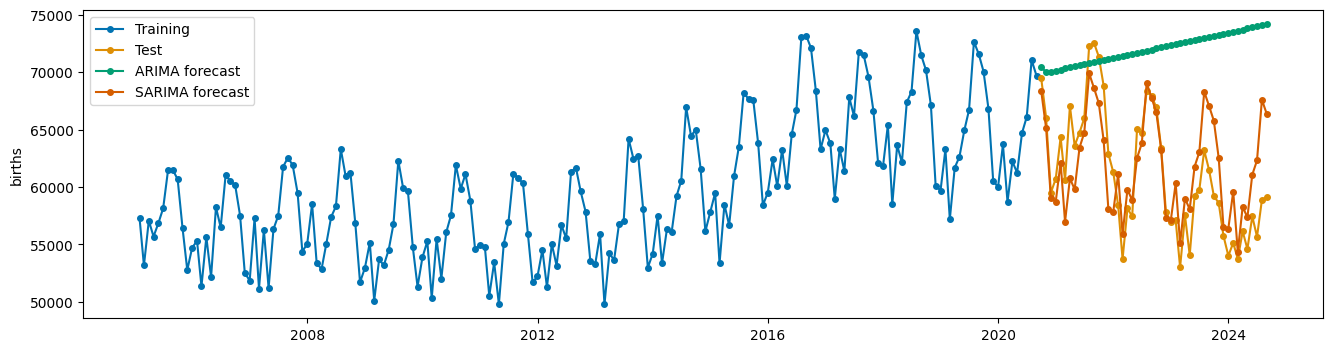

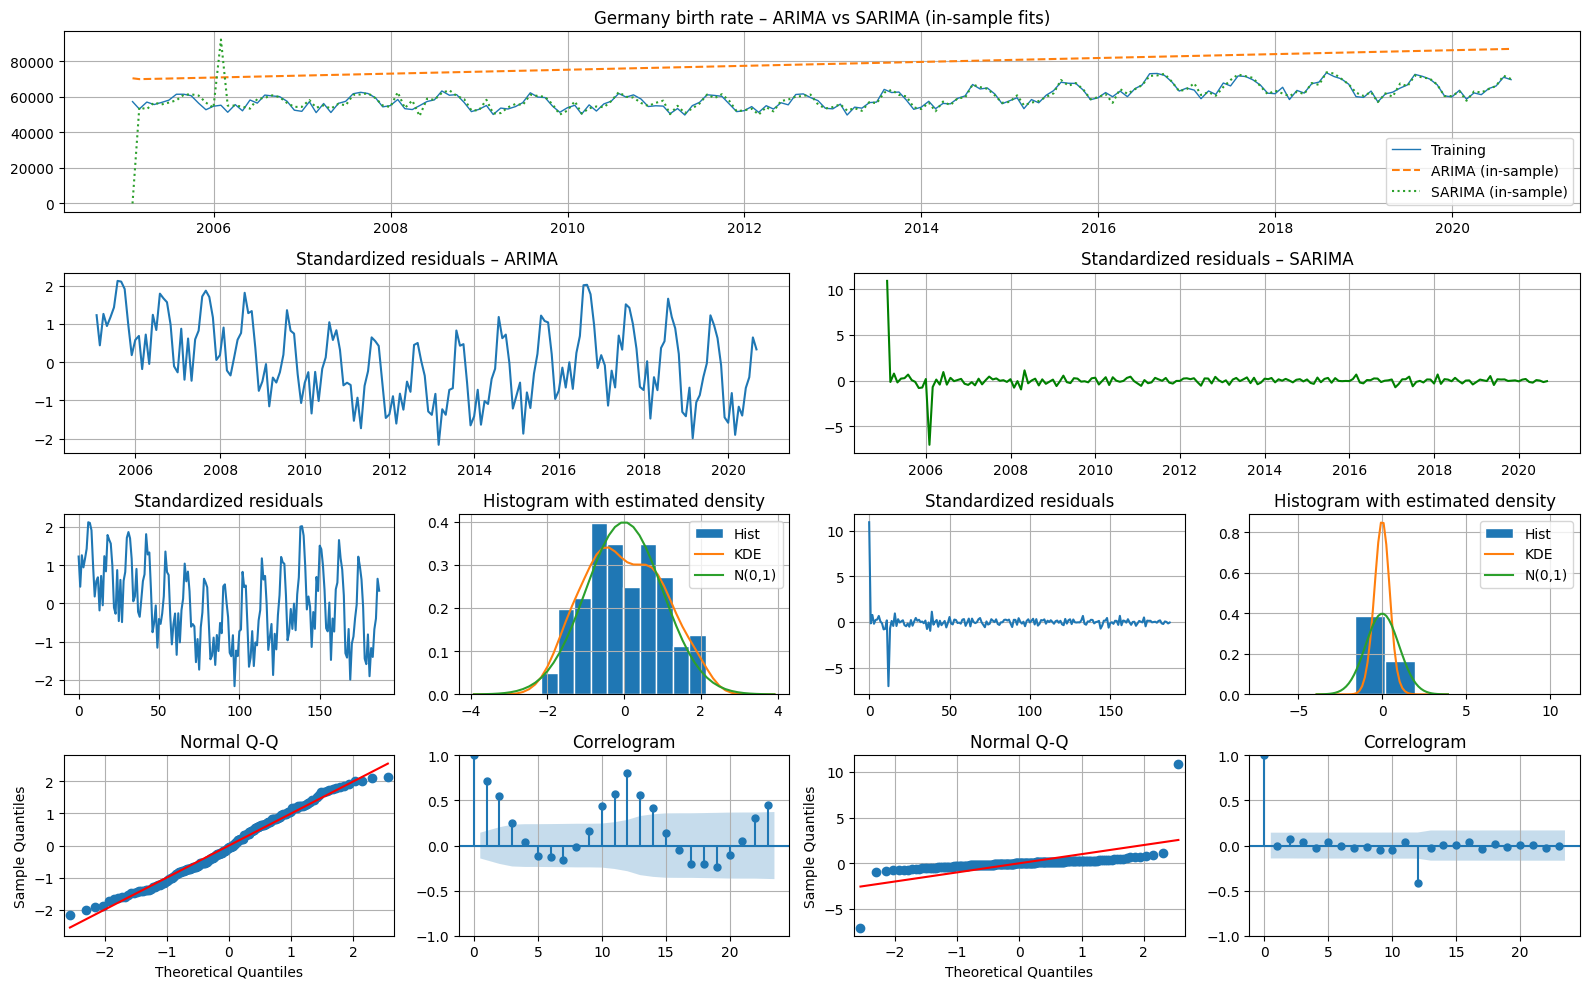

In [37]:
from sktime.forecasting.arima import ARIMA
from sktime.utils.plotting import plot_series

arima = ARIMA(order=(1, 1, 0))
arima.fit(full_train)
pred_arima = arima.predict(fh=fh)
pred_arima.index = test.index

# Seasonal period 12
sarima_model = sm.tsa.statespace.SARIMAX(
    full_train,
    order=(1, 1, 1),          
    seasonal_order=(1, 1, 1, 12),  
)
sarima_res = sarima_model.fit(disp=False)

# In-sample fitted values
fitted_sarima = sarima_res.fittedvalues

# Out-of-sample forecast for the test horizon
sarima_forecast = sarima_res.forecast(steps=len(test))
sarima_forecast = pd.Series(sarima_forecast, index=test.index)

plot_series(
    full_train,
    test,
    pred_arima,
    sarima_forecast,
    labels=["Training", "Test", "ARIMA forecast", "SARIMA forecast"],
)


fh_in_sample = np.arange(len(full_train))
arima_in_sample = arima.predict(fh=fh_in_sample)
arima_in_sample.index = full_train.index
resid_arima = full_train - arima_in_sample
resid_arima_std = (resid_arima - resid_arima.mean()) / resid_arima.std(ddof=1)

resid_sarima = sarima_res.resid
resid_sarima_std = (resid_sarima - resid_sarima.mean()) / resid_sarima.std(ddof=1)

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(4, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, :])      # top: original + fits
ax2 = fig.add_subplot(gs[1, :2])     # ARIMA residuals time plot
ax3 = fig.add_subplot(gs[1, 2:])     # SARIMA residuals time plot

arima_axs = [
    fig.add_subplot(gs[2, 0]),
    fig.add_subplot(gs[2, 1]),
    fig.add_subplot(gs[3, 0]),
    fig.add_subplot(gs[3, 1]),
]

sarima_axs = [
    fig.add_subplot(gs[2, 2]),
    fig.add_subplot(gs[2, 3]),
    fig.add_subplot(gs[3, 2]),
    fig.add_subplot(gs[3, 3]),
]

# training + ARIMA + SARIMA fits (on train index)
ax1.plot(full_train.index, full_train.values, label="Training", linewidth=1)
ax1.plot(full_train.index, arima_in_sample.values, label="ARIMA (in-sample)", linestyle="--")
ax1.plot(full_train.index, fitted_sarima.values, label="SARIMA (in-sample)", linestyle=":")
ax1.set_title("Germany birth rate – ARIMA vs SARIMA (in-sample fits)")
ax1.legend()
ax1.grid(True)

# Time plots of standardized residuals
ax2.plot(resid_arima_std, label="ARIMA residuals")
ax2.set_title("Standardized residuals – ARIMA")
ax2.grid(True)

ax3.plot(resid_sarima_std, label="SARIMA residuals", color="green")
ax3.set_title("Standardized residuals – SARIMA")
ax3.grid(True)

# Residual analysis plots
residual_analysis_plots(resid_arima_std, axs=arima_axs)
residual_analysis_plots(resid_sarima_std, axs=sarima_axs)

fig.tight_layout()
plt.show()


The ARIMA model captures the overall trend but fails to reproduce the clear seasonal pattern, leading to autocorrelated residuals. In contrast, the SARIMA model fits the seasonality much better, and its residuals are closer to white noise, with weaker autocorrelation and a distribution closer to normal. This indicates that including seasonal terms significantly improves the model performance.

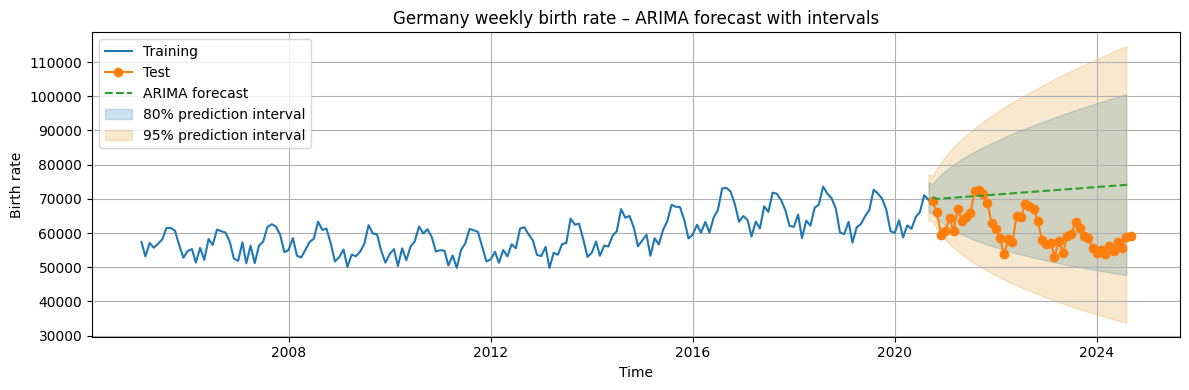

In [38]:
from sktime.utils.plotting import plot_interval

# Two coverages: 80% and 95%
pred_int = arima.predict_interval(fh=fh, coverage=[0.80, 0.95])

# Plot train, test, forecast, and intervals
fig, ax = time_plot(
    x=full_train.index,
    y=full_train,
    label="Training",
    title="Germany weekly birth rate – ARIMA forecast with intervals",
    xlabel="Time",
    ylabel="Birth rate",
    return_fig=True,
)

# Test observations
ax.plot(test.index, test, label="Test", marker="o")

# Point forecasts
ax.plot(pred_arima.index, pred_arima, label="ARIMA forecast", linestyle="--")

# Interval bands
plot_interval(ax, pred_int)

ax.legend()
fig.tight_layout()


The ARIMA forecast follows the overall trend but does not capture the seasonal fluctuations visible in the test data. Most test observations lie within the 95% prediction interval, while the 80% interval is narrower and misses some points.

#### Evaluation workflow

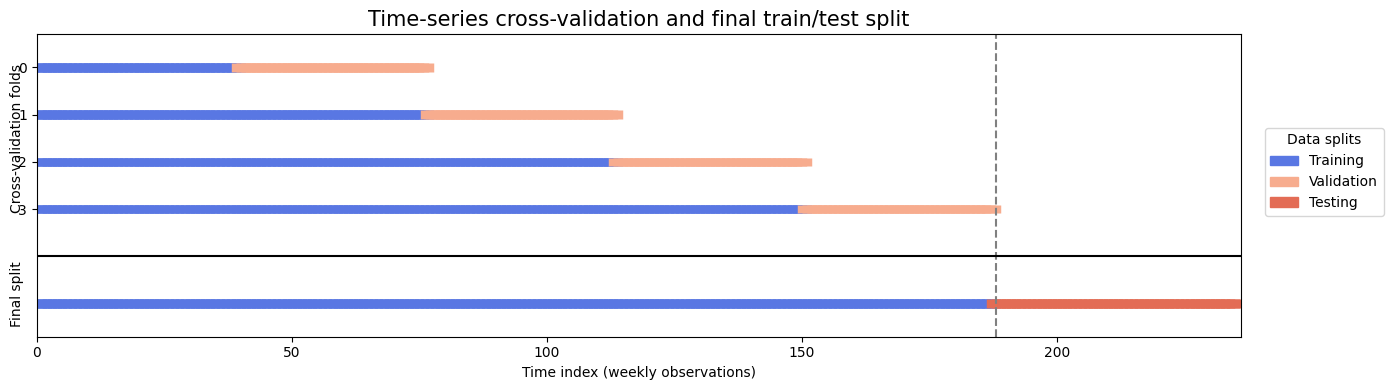

In [39]:
nsamples = len(y)
train_size = int(nsamples * 0.8)

samples = y.values
sample_index = np.arange(nsamples)

n_splits = 4
cv = TimeSeriesSplit(n_splits=n_splits)

cmap_cv = plt.cm.coolwarm
scatter_kwargs = {'lw': 14, 'marker': '|', 'cmap': cmap_cv, 'vmin': 0, 'vmax': 1}

fig, [ax] = get_figure(figsize=(14, 4))

# Cross-validation folds (on TRAIN only)
for ii, (tr, tt) in enumerate(cv.split(X=samples[:train_size])):
    indices = np.full(train_size, np.nan)
    indices[tr] = 0.1   # training
    indices[tt] = 0.7   # validation

    ax.scatter(
        range(train_size),
        [ii + 0.5] * train_size,
        c=indices,
        **scatter_kwargs,
    )

# Final train / test split
indices = np.zeros(nsamples) + 0.1       # train
indices[train_size:] = 0.85              # test

ax.scatter(
    range(nsamples),
    [ii + 2.5] * nsamples,
    c=indices,
    **scatter_kwargs,
)

# Formatting
ax.set(
    yticks=np.arange(n_splits) + 0.5,
    yticklabels=list(range(n_splits)),
    xlabel="Time index (weekly observations)",
    ylim=[n_splits + 2.2, -0.2],
    xlim=[0, nsamples],
)
ax.set_title("Time-series cross-validation and final train/test split", fontsize=15)

# Vertical line = start of test set
ax.axvline(x=train_size, color='gray', linestyle='--')

# Horizontal divider
ax.axhline(y=ii + 1.5, color='black', linestyle='-')

# Labels on the left
ax.text(-2.5, n_splits / 2, "Cross-validation folds", va='center', ha='right', rotation=90)
ax.text(-2.5, n_splits + 1.3, "Final split", va='center', ha='right', rotation=90)

ax.grid(False)

# Legend
ax.legend(
    [Patch(color=cmap_cv(0.1)), Patch(color=cmap_cv(0.7)), Patch(color=cmap_cv(0.85))],
    ["Training", "Validation", "Testing"],
    loc=(1.02, 0.4),
    title="Data splits"
)

fig.tight_layout()
plt.show()


/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/var/folders/rs/65df6vr950918gkv11r91kmh0000gn/T/ipykernel_33736/2504239800.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.predict(fh=[1])[0]
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be u

Rolling MAE:  2695.863
Rolling RMSE: 3328.324


/var/folders/rs/65df6vr950918gkv11r91kmh0000gn/T/ipykernel_33736/2504239800.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.predict(fh=[1])[0]
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/var/folders/rs/65df6vr950918gkv11r91kmh0000gn/T/ipykernel_33736/2504239800.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys

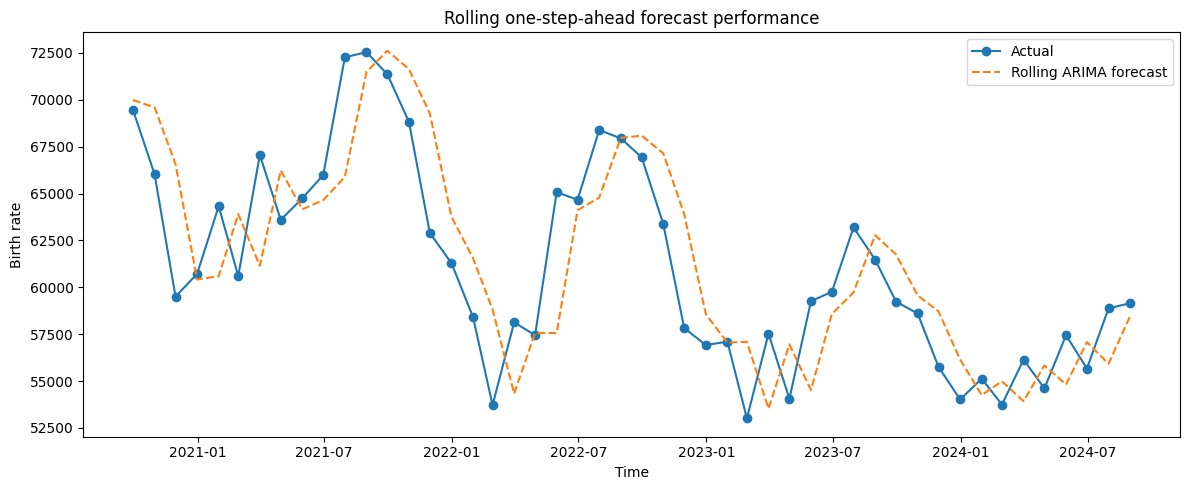

In [40]:
history = full_train.copy()
rolling_preds = []

for t in test.index:
    # Fit ARIMA on data available up to time t-1
    model = ARIMA(order=(1, 1, 0))
    model.fit(history)

    # One-step-ahead forecast
    y_hat = model.predict(fh=[1])[0]
    rolling_preds.append(y_hat)

    # Update history with the true observation
    history = pd.concat([history, test.loc[[t]]])

rolling_preds = pd.Series(rolling_preds, index=test.index)


errors = test - rolling_preds

mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))

print(f"Rolling MAE:  {mae:.3f}")
print(f"Rolling RMSE: {rmse:.3f}")


plt.figure(figsize=(12, 5))
plt.plot(test, label="Actual", marker="o")
plt.plot(rolling_preds, label="Rolling ARIMA forecast", linestyle="--")
plt.title("Rolling one-step-ahead forecast performance")
plt.xlabel("Time")
plt.ylabel("Birth rate")
plt.legend()
plt.tight_layout()
plt.show()



In [41]:
n_splits = 4
cv = TimeSeriesSplit(n_splits=n_splits)

rmse_scores = []
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(full_train)):
    y_train = full_train.iloc[train_idx]
    y_val = full_train.iloc[val_idx]

    fh = np.arange(1, len(y_val) + 1)

    model = ARIMA(order=(1, 1, 0))
    model.fit(y_train)

    y_pred = model.predict(fh=fh)
    y_pred.index = y_val.index

    errors = y_val - y_pred

    rmse_scores.append(np.sqrt(np.mean(errors**2)))
    mae_scores.append(np.mean(np.abs(errors)))

print("CV RMSE per fold:", rmse_scores)
print("CV MAE  per fold:", mae_scores)
print("Mean CV RMSE:", np.mean(rmse_scores))
print("Mean CV MAE :", np.mean(mae_scores))


CV RMSE per fold: [3845.8070058148237, 4295.083077127684, 4992.845655088778, 9443.806852486341]
CV MAE  per fold: [3030.1530438890773, 3379.114202590408, 4031.928268052699, 8251.62236879997]
Mean CV RMSE: 5644.385647629407
Mean CV MAE : 4673.204470833039


/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/ba

In [42]:

history = full_train.copy()
rolling_preds = []

for t in test.index:
    model = ARIMA(order=(1, 1, 0))
    model.fit(history)

    y_hat = model.predict(fh=[1])[0]
    rolling_preds.append(y_hat)

    history = pd.concat([history, test.loc[[t]]])

rolling_preds = pd.Series(rolling_preds, index=test.index)

errors = test - rolling_preds

rmse_rolling = np.sqrt(np.mean(errors**2))
mae_rolling = np.mean(np.abs(errors))

print("Rolling RMSE:", rmse_rolling)
print("Rolling MAE :", mae_rolling)


/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/var/folders/rs/65df6vr950918gkv11r91kmh0000gn/T/ipykernel_33736/745073983.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.predict(fh=[1])[0]
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be use

Rolling RMSE: 3328.323720516918
Rolling MAE : 2695.8628048355895


/var/folders/rs/65df6vr950918gkv11r91kmh0000gn/T/ipykernel_33736/745073983.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.predict(fh=[1])[0]


/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sktime/forecasting/base/_base.py:1186: UserWarning: empty y passed to update_predict of NaiveForecaster(strategy='drift'), no update was carried out
  warn(
/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sktime/forecasting/base/_base.py:1186: UserWarning: empty y passed to update_predict of NaiveForecaster(strategy='mean'), no update was carried out
  warn(


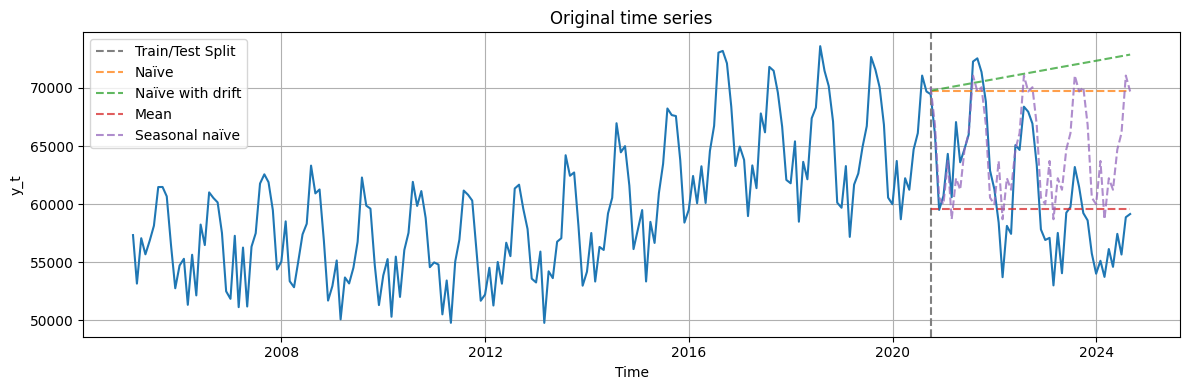

In [43]:

data = get_germany_births()
data["time"] = pd.to_datetime(data["time"])

y = data.set_index("time")["births"]

# Infer the frequency from the dates and set it
freq = pd.infer_freq(y.index)

if freq is not None:
    y = y.asfreq(freq)
else:
    # Fallback
    y = y.asfreq("M")  

fig, axes = get_figure()
ax = axes[0]

time_plot(
    x=y.index,
    y=y.values,
    title="Original time series",
    xlabel="Time",
    ylabel="y_t",
    ax=ax,
)

train_size = int(len(data) * 0.8)

ax.axvline(
    x=y.index[train_size],
    color="gray",
    linestyle="--",
    label="Train/Test Split"
)

baselines = baseline_forecasting(y, train_size, period=12)

for name, (_, pred, _) in baselines.items():
    ax.plot(pred.index, pred, label=name, linestyle="--", alpha=0.75)

ax.legend(loc="upper left")
fig.tight_layout()


The naive forecast assumes the future equals the last observed value and ignores both trend and seasonality.  
The naive with drift forecast extends the last value using a linear trend estimated from the training data.  
The mean forecast predicts a constant value equal to the historical average and does not react to changes over time.  
The seasonal naive forecast repeats values from the same season in the previous year and captures the seasonal pattern.

Overall, the seasonal naive method performs best among the baselines.


In [44]:
print(full_train.head())

2005-01-31    57338.0
2005-02-28    53165.0
2005-03-31    57071.0
2005-04-30    55684.0
2005-05-31    56866.0
Name: births, dtype: float64


In [45]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction

fh = np.arange(1, len(test) + 1)

rf_regressor = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
)

rf_forecaster = make_reduction(
    estimator=rf_regressor,
    strategy="recursive",
    window_length=12,      # last 12 points as features
    scitype="tabular-regressor",
)

rf_forecaster.fit(full_train)
y_pred_rf = rf_forecaster.predict(fh=fh)
y_pred_rf.index = test.index



In [46]:
import numpy as np
import pandas as pd

y = data  # if data is already a Series
if isinstance(data, pd.DataFrame):
    y = data.set_index("time")["births"]

y = y.sort_index()
y.index = pd.to_datetime(y.index)

# 80/20 split
train_size = int(len(y) * 0.8)
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# Forecast horizon for all models
fh = np.arange(1, len(y_test) + 1)

print(len(y_train), len(y_test))
print(y_train.head())
print(y_test.head())


188 48
time
2005-01-31    57338.0
2005-02-28    53165.0
2005-03-31    57071.0
2005-04-30    55684.0
2005-05-31    56866.0
Name: births, dtype: float64
time
2020-09-30    69457.0
2020-10-31    66019.0
2020-11-30    59502.0
2020-12-31    60716.0
2021-01-31    64325.0
Name: births, dtype: float64


In [47]:
from sktime.forecasting.naive import NaiveForecaster

# Ensure y_train has a frequency set
if y_train.index.freq is None:
	y_train = y_train.asfreq(pd.infer_freq(y_train.index) or "M")

baselines = {}

# Mean forecaster
mean_f = NaiveForecaster(strategy="mean")
mean_f.fit(y_train)
y_pred_mean = mean_f.predict(fh=fh)
y_pred_mean.index = y_test.index
baselines["Mean"] = y_pred_mean

# Naïve (last observed value)
naive_f = NaiveForecaster(strategy="last")
naive_f.fit(y_train)
y_pred_naive = naive_f.predict(fh=fh)
y_pred_naive.index = y_test.index
baselines["Naive"] = y_pred_naive

# Seasonal naïve – monthly data → sp=12
seasonal_f = NaiveForecaster(strategy="last", sp=12)
seasonal_f.fit(y_train)
y_pred_seasonal = seasonal_f.predict(fh=fh)
y_pred_seasonal.index = y_test.index
baselines["Seasonal Naive"] = y_pred_seasonal


In [48]:
from sktime.forecasting.arima import ARIMA

arima_model = ARIMA(order=(1, 1, 0))
arima_model.fit(y_train)
y_pred_arima = arima_model.predict(fh=fh)
y_pred_arima.index = y_test.index


In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Monthly data → seasonal period 12
sarima_model = SARIMAX(
    y_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_res = sarima_model.fit(disp=False)

y_pred_sarima = sarima_res.forecast(steps=len(y_test))
y_pred_sarima = pd.Series(y_pred_sarima, index=y_test.index, name="SARIMA")


In [50]:
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction

rf_regressor = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
)

rf_forecaster = make_reduction(
    estimator=rf_regressor,
    strategy="recursive",
    window_length=12,            # last 12 months as features
    scitype="tabular-regressor", 
)

rf_forecaster.fit(y_train)
y_pred_rf = rf_forecaster.predict(fh=fh)
y_pred_rf.index = y_test.index


In [51]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

exp_model = ExponentialSmoothing(trend="add", seasonal="add", sp=12)
exp_model.fit(y_train)
y_pred_exp = exp_model.predict(fh=fh)
y_pred_exp.index = y_test.index


/Users/nadine/.pyenv/versions/3.12.6/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [52]:
from sktime.forecasting.theta import ThetaForecaster

# Convert y_train to PeriodIndex if necessary
if not isinstance(y_train.index, pd.PeriodIndex):
	freq = pd.infer_freq(y_train.index)
	# Replace 'ME' with 'M' for compatibility with PeriodIndex
	if freq == 'ME':
		freq = 'M'
	elif freq is None:
		freq = "M"
	y_train_period = y_train.copy()
	y_train_period.index = pd.to_datetime(y_train_period.index).to_period(freq)
else:
	y_train_period = y_train

theta_model = ThetaForecaster(sp=12)
theta_model.fit(y_train_period)

y_pred_theta = theta_model.predict(fh=fh)
if isinstance(y_pred_theta.index, pd.PeriodIndex):
	y_pred_theta.index = y_pred_theta.index.to_timestamp(how="end")

# Ensure the final index matches y_test
y_pred_theta.index = y_test.index


In [53]:
from sktime.forecasting.ets import AutoETS

# Let AutoETS pick the best ETS (error/trend/seasonal) model
ets_model = AutoETS(auto=True, sp=12, n_jobs=-1)
ets_model.fit(y_train)
y_pred_ets = ets_model.predict(fh=fh)
y_pred_ets.index = y_test.index


In [54]:
from sktime.forecasting.trend import PolynomialTrendForecaster


poly_model = PolynomialTrendForecaster(degree=1)
poly_model.fit(y_train)
y_pred_poly = poly_model.predict(fh=fh)
y_pred_poly.index = y_test.index


In [55]:
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

preds = {
    "Mean": y_pred_mean,
    "Naive": y_pred_naive,
    "Seasonal Naive": y_pred_seasonal,
    "ARIMA": y_pred_arima,
    "SARIMA": y_pred_sarima,
    "Random Forest": y_pred_rf,
    "ExpSmoothing": y_pred_exp,
    "Theta": y_pred_theta,
    "AutoETS": y_pred_ets,
    "PolyTrend": y_pred_poly,
}

rows = []
for name, y_hat in preds.items():
    mae = mean_absolute_error(y_test, y_hat)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    rows.append({"Model": name, "MAE": mae, "RMSE": rmse})

results = pd.DataFrame(rows).set_index("Model").sort_values("RMSE")
print(results)


                         MAE          RMSE
Model                                     
SARIMA           3195.273903   3939.848523
AutoETS          4227.000274   5229.402332
Seasonal Naive   4363.833333   5375.198651
Mean             4400.541667   5505.338670
ExpSmoothing     4660.564128   5755.574286
Random Forest    4958.820937   6074.728072
Theta            4858.518683   6076.498102
PolyTrend        7146.929900   8419.833348
Naive            8867.958333  10069.951632
ARIMA           11132.516692  12599.552188


The SARIMA model achieves the lowest MAE and RMSE, indicating the best forecasting performance among all models. Models that include seasonality, such as SARIMA and Seasonal Naive, clearly outperform non-seasonal approaches. In contrast, ARIMA and Naive models show the largest errors, confirming that ignoring seasonality leads to poor forecasts. Overall, incorporating seasonal structure is essential for accurate prediction of this time series.


In [56]:
best_name = results.index[0]
print("Best model:", best_name)

best_pred = preds[best_name]


Best model: SARIMA


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='births'>)

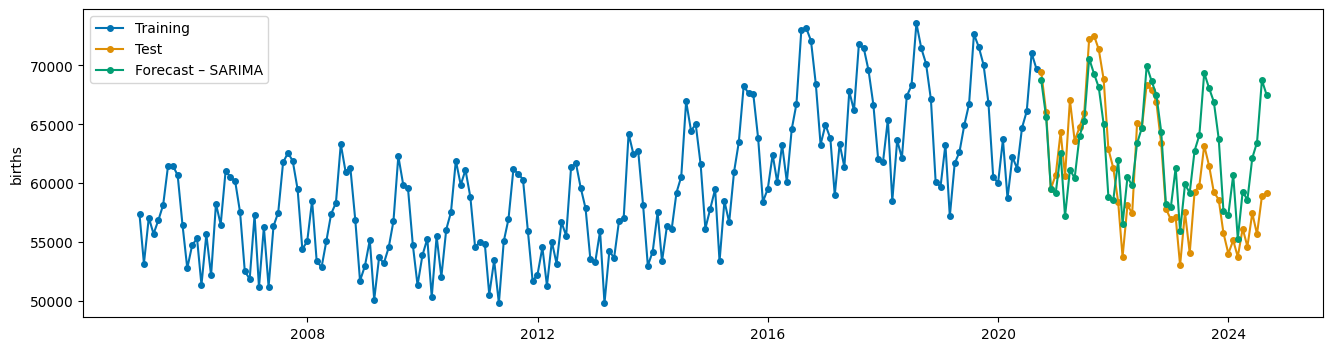

In [57]:
from sktime.utils.plotting import plot_series

plot_series(
    y_train,
    y_test,
    best_pred,
    labels=["Training", "Test", f"Forecast – {best_name}"],
)
